In [ ]:
import torch
import torchvision
from torchvision import transforms
from skimage import io, transform
from torch import nn

import json

import numpy as np
import pandas as pd

import train
import imp 
imp.reload(train)

from losses import *
from train import *
from plots import *
from gan import *
from data import *

import train
import imp 
imp.reload(train)

from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
BATCH_SIZE = 16
LR = 2e-4
MAX_LR = 5e-4
BETAS = 0.5, 0.999
LOGS_DIR = F"/content/drive/MyDrive/attack_wgan_logdir_bare"
DEVICE='cuda'
LAMBDA = 0.5

In [ ]:
data = FacesDataset("/content/drive/MyDrive/vgg_data/", transform=lambda x: (torch.tensor(transform.resize(np.array(x['image']), (160, 160))).permute((2, 0, 1)), x['class']))
train_data = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)

/content/drive/MyDrive/vgg_data/Bingbing_Fan/794.jpg
/content/drive/MyDrive/vgg_data/Andrew_Buchan/295.jpg
/content/drive/MyDrive/vgg_data/Thad_Luckinbill/405.jpg
/content/drive/MyDrive/vgg_data/Nelly/757.jpg


In [ ]:
classifier = InceptionResnetV1(pretrained='casia-webface', device=DEVICE).eval()
classifier.classify = True

In [ ]:
model = {"generator": Generator(in_channels=3, out_channels=3, image_size=160).to(device=DEVICE), 
         "discriminator": Discriminator(in_channels=3, image_size=160, gp=True).to(device=DEVICE),
         'attacked_model': classifier.to(device=DEVICE).eval()}
loss = {"generator": WGANGeneratorLoss(), #GeneratorLoss(BATCH_SIZE, DEVICE), 
             "discriminator": WGANDiscriminatorLoss(LAMBDA, DEVICE), #DiscriminatorLoss(BATCH_SIZE, DEVICE), 
             "attack": AttackLoss(),
             "hinge": HingeLoss(BATCH_SIZE, DEVICE)}
optimizer = {
    "generator": torch.optim.Adam(model['generator'].parameters(), lr=LR, betas=BETAS),
    "discriminator": torch.optim.Adam(model['discriminator'].parameters(), lr=LR, betas=BETAS),
}

scheduler = {
    "generator": torch.optim.lr_scheduler.CyclicLR(optimizer['generator'], LR, MAX_LR, cycle_momentum=False),
    "discriminator": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer['generator'], patience=3)
}

In [ ]:
model['generator'].load_state_dict(torch.load('/content/drive/MyDrive/attack_wgan_logdir_bare/models/gen_checkpoint_3'))
model['discriminator'].load_state_dict(torch.load('/content/drive/MyDrive/attack_wgan_logdir_bare/models/disc_checkpoint_3'))

<All keys matched successfully>

In [ ]:
trainer = CustomTrainer(model,
                        optimizer,
                        scheduler,
                        loss,
                        DEVICE,
                        log_path=LOGS_DIR,
                        image_path='./10.jpg',
                        penalty=True,
                        clean=False,
                        start_epoch=3)

In [ ]:
trainer.train(train_data, 7)

In [ ]:
attacked_model = model['attacked_model']
generator_model = model['generator']

In [ ]:
val_batch = iter(torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)).next()[0].to(device='cuda', dtype=torch.float)
for i in range(8):
    print(np.argmax(F.softmax(attacked_model(val_batch), -1).cpu().detach().numpy()[i]), np.argmax(F.softmax(attacked_model(generator_model(val_batch)[0]), -1).cpu().detach().numpy()[i]))

390 1649
2008 4112
40 40
772 138
654 58
9394 9130
609 4817
6328 6535


Text(0.5, 1.0, 'Fake: Prediction: 8314, confidence: 0.03057773970067501')

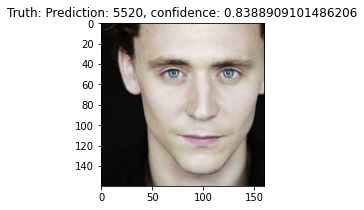

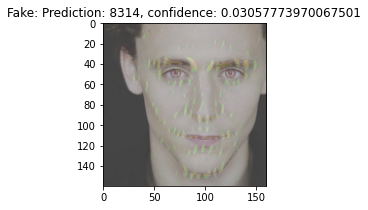

In [ ]:
test_tensor = torch.tensor(transform.resize(np.array(Image.open('./229.jpg')), (160, 160)), device='cuda', dtype=torch.float).permute((2, 0, 1)).unsqueeze(0)
test_img = test_tensor.cpu().detach().numpy()

true_confs = F.softmax(attacked_model(test_tensor), -1).cpu().detach().numpy()[0]
fake_confs = F.softmax(attacked_model((generator_model(test_tensor)[0])), -1).cpu().detach().numpy()[0]

plt.figure(figsize=(3,3))
true_image = test_img[0].transpose((1, 2, 0))
plt.imshow(true_image)
plt.title("Truth: Prediction: {}, confidence: {}".format(np.argmax(true_confs), true_confs.max()))

plt.figure(figsize=(3,3))
false_image = ((generator_model(test_tensor)[0].cpu().detach().numpy()))[0].transpose((1, 2, 0))
plt.imshow(false_image)
plt.title("Fake: Prediction: {}, confidence: {}".format(np.argmax(fake_confs), fake_confs.max()))

In [ ]:
Image.fromarray((true_image * 255).astype(np.uint8)).save('./true.jpg')
Image.fromarray((false_image * 255).astype(np.uint8)).save('./false.jpg')

In [ ]:
results = pd.read_csv(os.path.join(LOGS_DIR, 'metrics.csv'))
results

,generator_loss,discriminator_loss,attack_loss,hinge_loss,epoch,batch
0,-0.501662,0.500056,-1.789053,87.117737,0,0
1,-0.505189,0.499133,-1.868290,86.486420,0,1
2,-0.508794,0.498024,-1.731786,86.080635,0,2
3,-0.512643,0.496653,-2.600534,85.621155,0,3
4,-0.517621,0.495258,-2.044440,85.454948,0,4
...,...,...,...,...,...,...
19770,-0.865932,-0.495691,-3.798281,69.850739,9,1814
19771,-0.942178,-0.661728,-3.962837,69.980408,9,1815
19772,-0.968274,-0.504293,-4.324076,69.996948,9,1816
19773,-0.961942,-0.579975,-3.920903,69.938553,9,1817


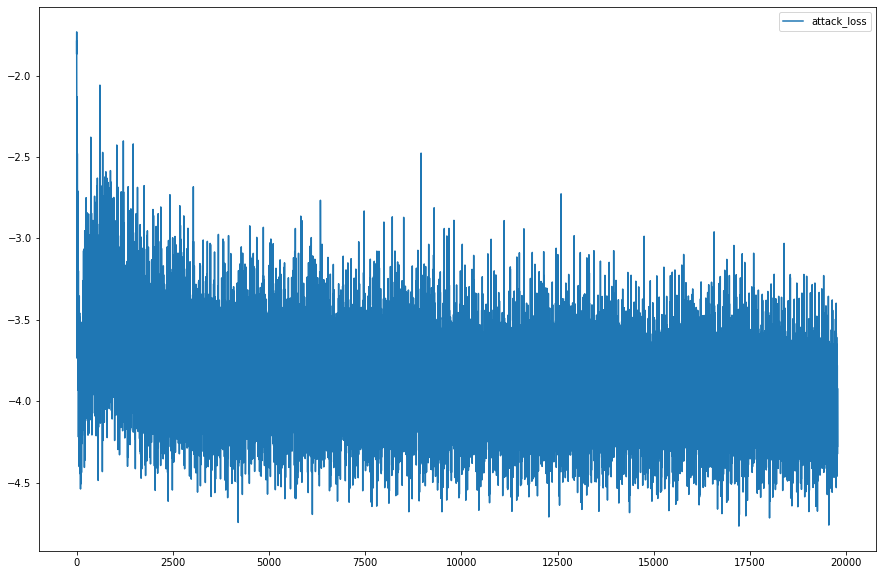

In [ ]:
results[['attack_loss']].plot(figsize=(15, 10))

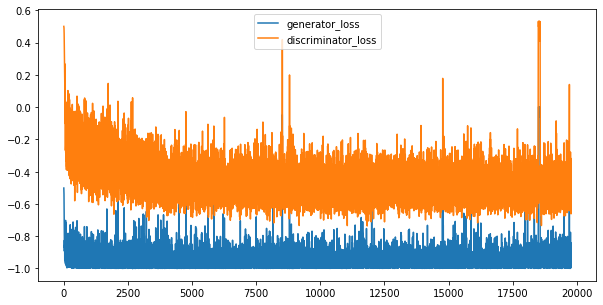

In [ ]:
results[['generator_loss', 'discriminator_loss']].plot(figsize=(10, 5))